In [1]:
import os 
import json 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

2023-05-23 14:43:50.559272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 14:44:13.334246: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 14:44:16.010260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/libfabric/lib:/sw/isaac/compilers/intel/one

In [19]:
filepath = '/lustre/isaac/scratch/tmengel/jet-background-subtraction/hyperparameter-tuning/runs'
runs = os.listdir(filepath)
mse = []
features = {}
feature_list = []
average_mse = []
trainable_params = []
nvars = []
for run in runs:
    runfile = {} 
    filename = f'{filepath}/{run}'
    with open(filename) as f:
        runfile = json.load(f)
    for run_number in runfile:
        
        mse.append(runfile[run_number]['loss'])
        trainable_params.append(runfile[run_number]['trainable_parms'])
       
        nvars_tmp = 0
        for var in runfile[run_number]['variables']:
            for key in var:
                if key not in feature_list:
                    feature_list.append(key)
                    features[key] = []
                features[key].append(runfile[run_number]['loss'])
                nvars_tmp += 1
        nvars.append(nvars_tmp)
    

In [2]:
top_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0"]

inputlen = len(top_features)

model = keras.Sequential(
            [
                layers.Dense(inputlen+1,input_shape=(inputlen,),activation='relu',kernel_initializer='he_uniform'),
                layers.Dense(1, activation='linear',kernel_initializer='he_uniform'),
            ])

top_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0",
                        "jet_track_pt_1","jet_track_pt_2","jet_track_pt_3","jet_track_pt_4",
                        "jet_track_pt_5","jet_track_pt_6","jet_track_pt_7"]

model.summary()
inputlen = len(top_features)
model = keras.Sequential(
            [
                layers.Dense(100,input_shape=(inputlen,),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
                layers.Dense(100, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
                layers.Dense(50, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
                layers.Dense(1, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
            ])
model.summary()


2023-05-23 14:45:24.832067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/libfabric/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/lib/release:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/ippcp/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/ipp/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/itac/latest/slib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mkl/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib/x64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib/emu:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/compiler/lib/intel64_lin:/sw/isaac/compil

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               1300      
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 50

In [5]:
pdf = pd.read_hdf("/lustre/isaac/scratch/tmengel/jet-background-subtraction/datasets/root-files/AuAu_R04/test/AuAu_R04_50_test_sample.h5", key='df')

top_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0",
                        "jet_track_pt_1","jet_track_pt_2","jet_track_pt_3","jet_track_pt_4",
                        "jet_track_pt_5","jet_track_pt_6","jet_track_pt_7"]

inputlen = len(top_features)
model = keras.Sequential(
            [
                layers.Dense(100,input_shape=(inputlen,),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
                layers.Dense(100, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
                layers.Dense(50, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
                layers.Dense(1, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)),
            ])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(pdf[top_features], pdf['jet_pt_truth'], epochs=25, batch_size=100, verbose=1, validation_split=0.2)
mse_dnn = model.evaluate(pdf[top_features], pdf['jet_pt_truth'], verbose=0)[1]
n_trainible_params_dnn = model.count_params()



In [9]:
top_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0"]

inputlen = len(top_features)
model = keras.Sequential(
            [
                layers.Dense(inputlen+1,input_shape=(inputlen,),activation='relu',kernel_initializer='he_uniform'),
                layers.Dense(1, activation='linear',kernel_initializer='he_uniform'),
            ])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(pdf[top_features], pdf['jet_pt_truth'], epochs=25, batch_size=100, verbose=1, validation_split=0.2)
mse_snn = model.evaluate(pdf[top_features], pdf['jet_pt_truth'], verbose=0)[1]
n_trainible_params_snn = model.count_params()

In [121]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(246.0, 1.5)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})

dnn = dict(color='blue',  marker='s', alpha=1.0, label='Deep Neural Network', s=30)
snn = dict(color='red',  marker='^', alpha=1.0, label='Shallow Neural Network', s=30)

trainable_params = np.array(trainable_params)
mse = np.array(mse)
trainable_params = trainable_params[mse < 100]
mse = mse[mse < 100]
fig = plt.figure(dpi=600,figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(trainable_params, mse, color='k', s=10, alpha=0.5, marker='o')
ax.scatter(n_trainible_params_dnn, mse_dnn, **dnn)
ax.scatter(n_trainible_params_snn, mse_snn, **snn)
ax.set_xlabel('Number of Trainable Parameters')
ax.set_ylabel(r'Mean Squared Error $(GeV^2)$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Loss vs. Complexity for Sampled Model Architectures')
ax.legend(loc='lower left', frameon=False)
plt.tight_layout()
plt.show()
fig.savefig('plots/MSE_vs_Complexity.pdf')


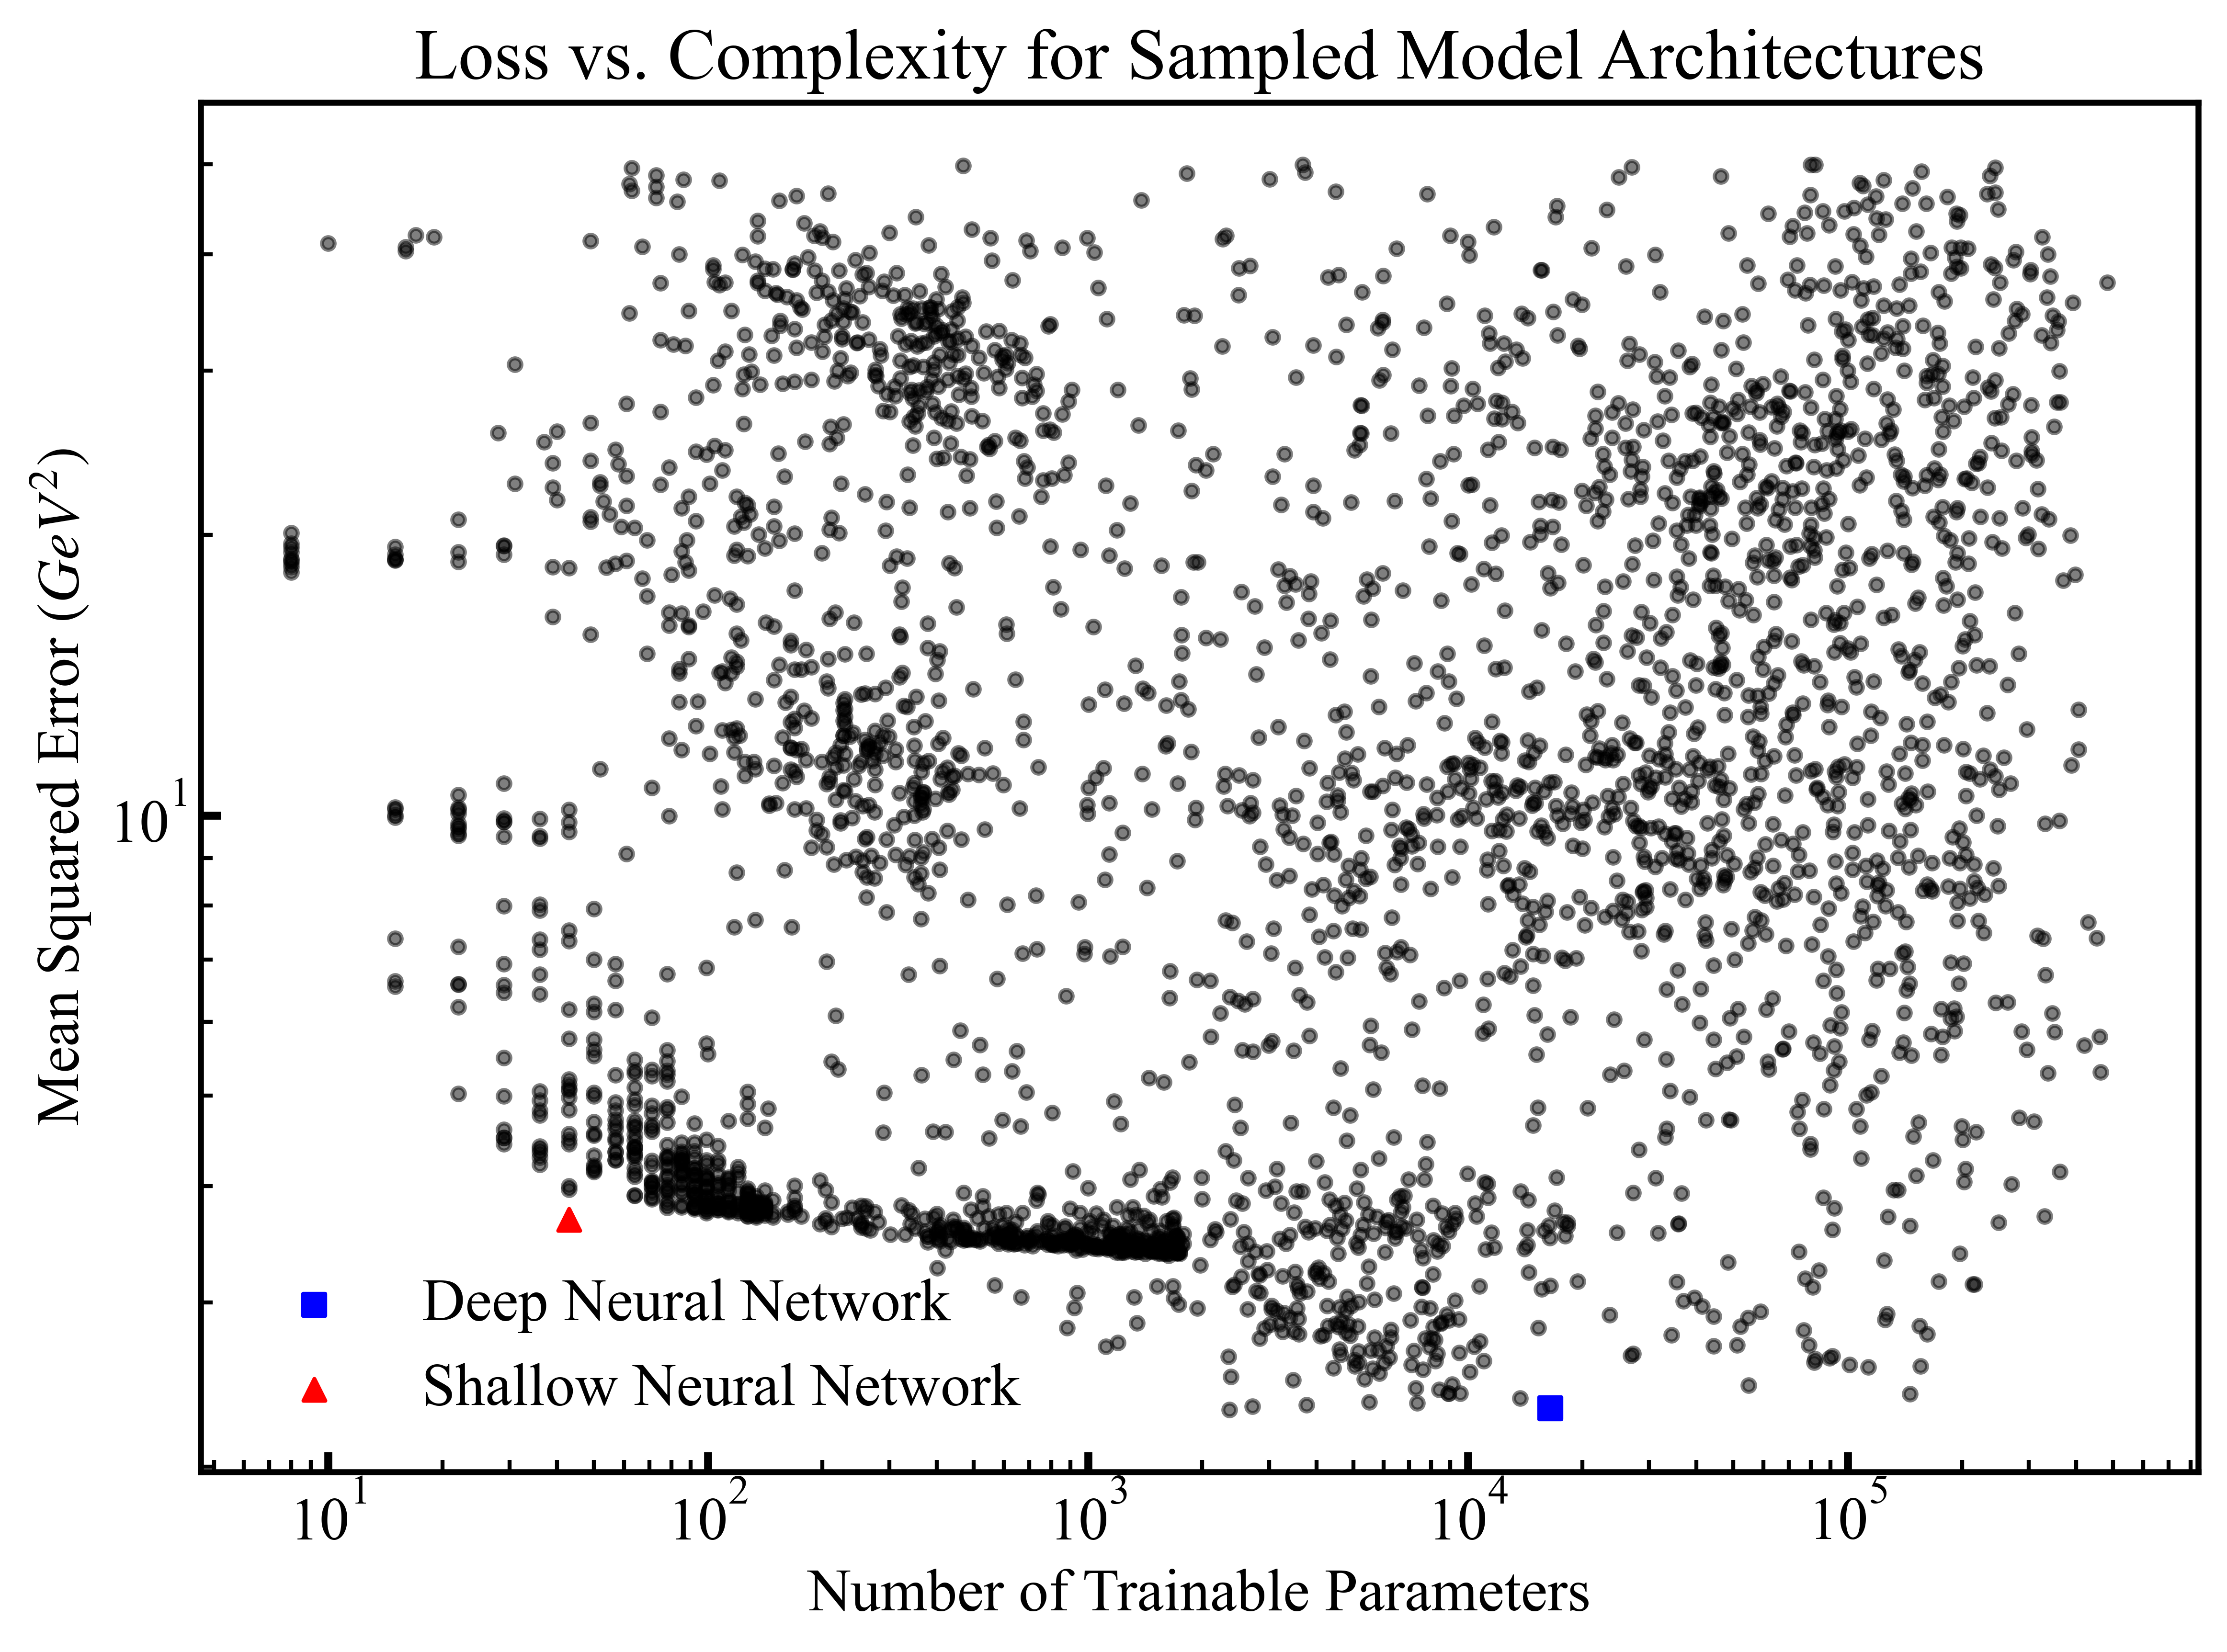

<Figure size 432x288 with 0 Axes>

In [125]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(246.0, 1.5)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})

dnn = dict(color='blue',  marker='s', alpha=1.0, label='Deep Neural Network', s=30)
snn = dict(color='red',  marker='^', alpha=1.0, label='Shallow Neural Network', s=30)

trainable_params = np.array(trainable_params)
mse = np.array(mse)
trainable_params = trainable_params[mse < 100]
mse = mse[mse < 100]
fig = plt.figure(dpi=600,figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(trainable_params, mse, color='k', s=10, alpha=0.5, marker='o')
ax.scatter(n_trainible_params_dnn, mse_dnn, **dnn)
ax.scatter(n_trainible_params_snn, mse_snn, **snn)
ax.set_xlabel('Number of Trainable Parameters')
ax.set_ylabel(r'Mean Squared Error $(GeV^2)$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Loss vs. Complexity for Sampled Model Architectures')
ax.legend(loc='lower left', frameon=False)
plt.tight_layout()
plt.show()
fig.savefig('pdf/MSE_vs_Complexity.pdf', bbox_inches='tight')
fig.savefig('png/MSE_vs_Complexity.png', bbox_inches='tight')
